In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from core.problem import ElementwiseProblem
from algorithms.moo.nsga2 import NSGA2
from constraints.as_obj import ConstraintsAsObjective
from constraints.as_obj import ModifiedConstraintsAsObjective
from constraints.from_bounds import ConstraintsFromBounds
from constraints.as_penalty import ConstraintsAsPenalty
from gradient.automatic import MyAutomaticDifferentiation
from optimize import minimize
from visualization.scatter import Scatter

In [3]:
algorithm = NSGA2(pop_size=100)

In [4]:
class ConstrainedProblem(ElementwiseProblem):

    def __init__(self, **kwargs):
        super().__init__(n_var=2, n_obj=1, n_ieq_constr=1, n_eq_constr=0, xl=0, xu=2, **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = x[0] ** 2 + x[1] ** 2
        out["G"] = 1.0 - (x[0] + x[1])

In [5]:
problem = ConstrainedProblem()

# plot = Scatter()
# plot.add(problem.pareto_front(), marker="*", color="black", alpha=0.7, s=100)
# plot.add(res.F, facecolor="none", edgecolor="red")
# plot.show()

In [6]:
res1 = minimize(ConstraintsAsObjective(problem),
                algorithm,
                ('n_gen', 300),
                seed=1,
                verbose=False)

In [7]:
res2 = minimize(ModifiedConstraintsAsObjective(problem),
                algorithm,
                ('n_gen', 300),
                seed=1,
                verbose=False)

In [8]:
from pymoo.core.evaluator import Evaluator
from pymoo.core.individual import Individual

cv = res1.F[:, 0]
least_infeas = cv.argmin()
x = res1.X[least_infeas]

sol = Individual(X=x)
Evaluator().eval(problem, sol)

print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (sol.X, sol.F, sol.CV))

Best solution found: 
X = [0.50192841 0.49807354]
F = [0.50000937]
CV = [0.]


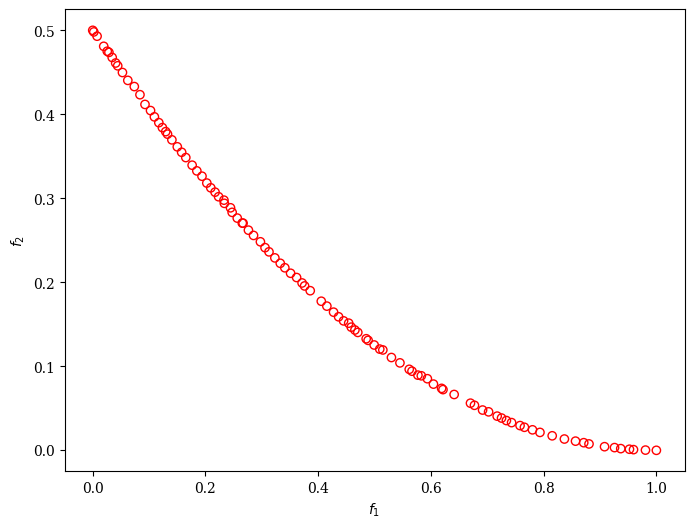

In [9]:
plot = Scatter()
plot.add(problem.pareto_front(), marker="*", color="black", alpha=0.7, s=100)
plot.add(res1.F, facecolor="none", edgecolor="red")
plot.show()

In [10]:
cv = res2.F[:, 0]
least_infeas = cv.argmin()
x = res2.X[least_infeas]

sol = Individual(X=x)
Evaluator().eval(problem, sol)

print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (sol.X, sol.F, sol.CV))

Best solution found: 
X = [0.49015048 0.50988775]
F = [0.50023301]
CV = [0.]


In [11]:
res2.F.shape

(100, 3)

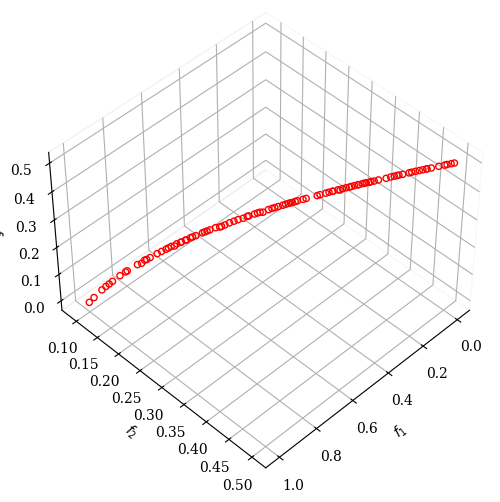

In [12]:
plot = Scatter()
plot.add(problem.pareto_front(), marker="*", color="black", alpha=0.7, s=100)
plot.add(res2.F, facecolor="none", edgecolor="red")
plot.show()

# ZDT

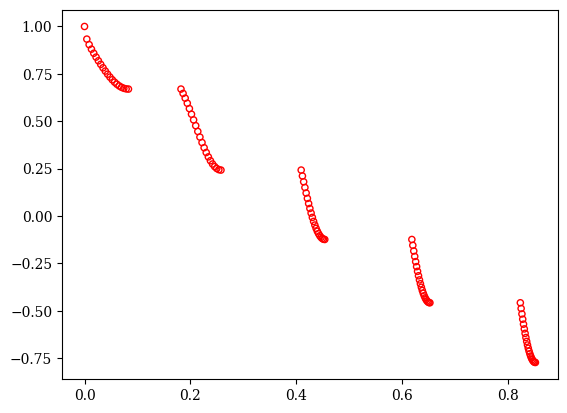

In [28]:
from pymoo.problems import get_problem
from pymoo.util.plotting import plot

problem2 = get_problem("zdt3")
plot(problem2.pareto_front(), no_fill=True)

In [30]:
res3 = minimize(ModifiedConstraintsAsObjective(problem2),
                algorithm,
                ('n_gen', 300),
                seed=1,
                save_history=True,
                verbose=False)

In [31]:
cv = res3.F[:, 0]
least_infeas = cv.argmin()
x = res3.X[least_infeas]

sol = Individual(X=x)
Evaluator().eval(problem2, sol)

print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (sol.X, sol.F, sol.CV))

Best solution found: 
X = [8.51659640e-01 2.55289251e-05 1.64149687e-04 1.50819597e-05
 4.57257527e-05 4.04556329e-06 6.43273625e-05 5.83182062e-06
 2.09636948e-05 1.42454499e-05 7.04504379e-05 1.60476676e-04
 1.30382844e-04 1.82404130e-05 1.89221938e-05 6.97291149e-06
 1.81411062e-05 2.93324774e-06 1.45448126e-05 2.48031927e-06
 2.91474269e-05 1.19954232e-04 1.43529387e-04 4.73500093e-05
 9.29764200e-05 2.55313181e-05 7.31722151e-05 1.89690168e-05
 2.32406594e-05 3.49641438e-05]
F = [ 0.85165964 -0.77312029]
CV = [0.]


In [32]:
res3.F.shape

(100, 5)

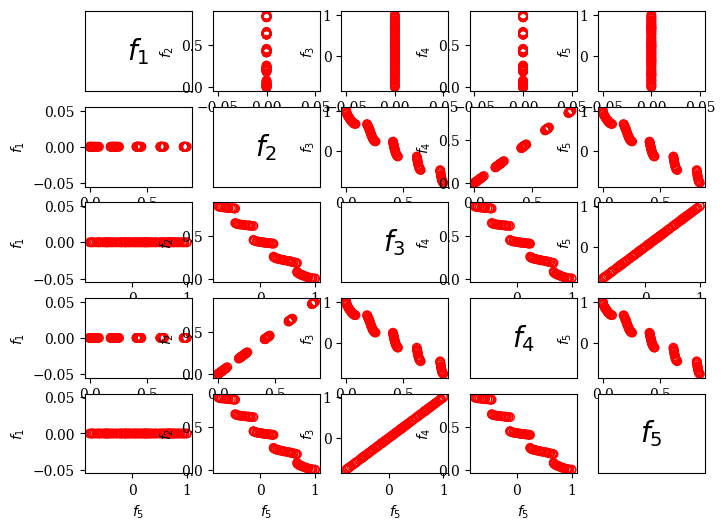

In [33]:
plot = Scatter()
# plot.add(problem.pareto_front(), marker="*", color="black", alpha=0.7, s=100)
plot.add(res3.F, facecolor="none", edgecolor="red")
plot.show()

In [34]:
X, F = res3.opt.get("X", "F")
hist = res3.history
print(len(hist))

300


In [35]:
n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population

for algo in hist:

    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

In [36]:
k = np.where(np.array(hist_cv) <= 0.0)[0].min()
print(f"At least one feasible solution in Generation {k} after {n_evals[k]} evaluations.")

At least one feasible solution in Generation 0 after 100 evaluations.


Whole population feasible in Generation 0 after 100 evaluations.


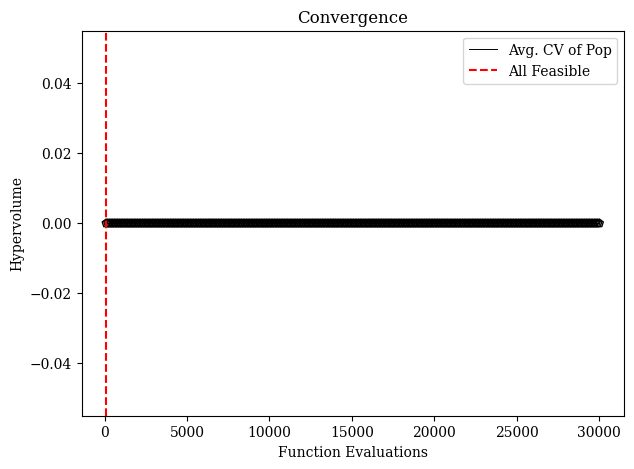

In [37]:
# replace this line by `hist_cv` if you like to analyze the least feasible optimal solution and not the population
vals = hist_cv_avg

k = np.where(np.array(vals) <= 0.0)[0].min()
print(f"Whole population feasible in Generation {k} after {n_evals[k]} evaluations.")

plt.figure(figsize=(7, 5))
plt.plot(n_evals, vals,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, vals,  facecolor="none", edgecolor='black', marker="p")
plt.axvline(n_evals[k], color="red", label="All Feasible", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.legend()
plt.show()

In [46]:
approx_ideal = F[:,-2:].min(axis=0)
approx_nadir = F[:,-2:].max(axis=0)
approx_ideal, approx_nadir

(array([ 1.56010819e-07, -7.73120286e-01]), array([0.85165964, 0.99993753]))

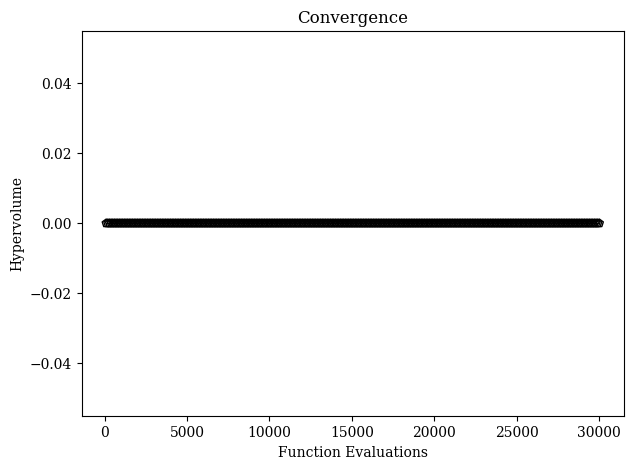

In [47]:
from pymoo.indicators.hv import Hypervolume

metric = Hypervolume(ref_point=np.array([0.1, 0.1]),
                     norm_ref_point=False,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F[:, -2:]) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv, color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv, facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()

/home/ha/.local/lib/python3.10/site-packages/pymoo/termination/ftol.py:14: RuntimeWarning: invalid value encountered in divide
  return np.max(np.abs((a - b) / norm))


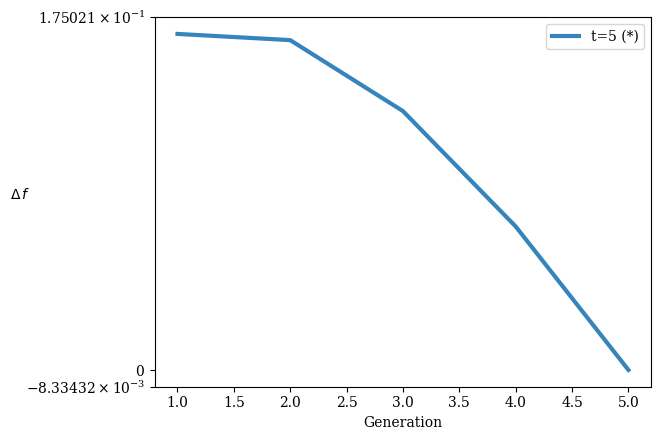

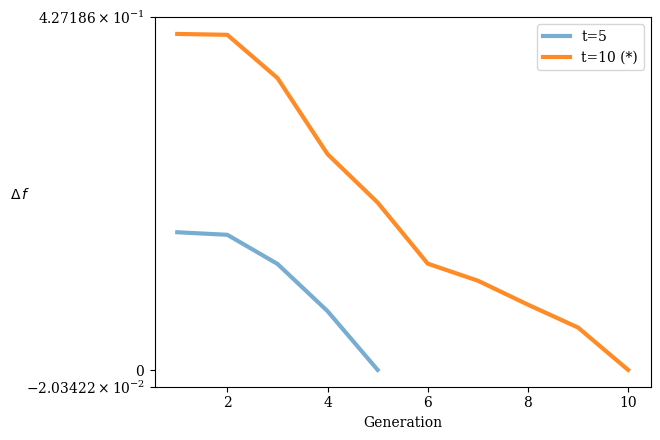

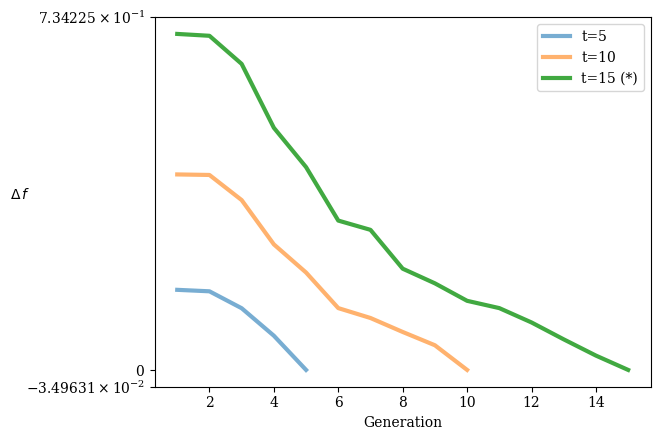

In [41]:
from pymoo.util.running_metric import RunningMetricAnimation

running = RunningMetricAnimation(delta_gen=5,
                        n_plots=3,
                        key_press=False,
                        do_show=True)

for algorithm in res3.history[:15]:
    running.update(algorithm)

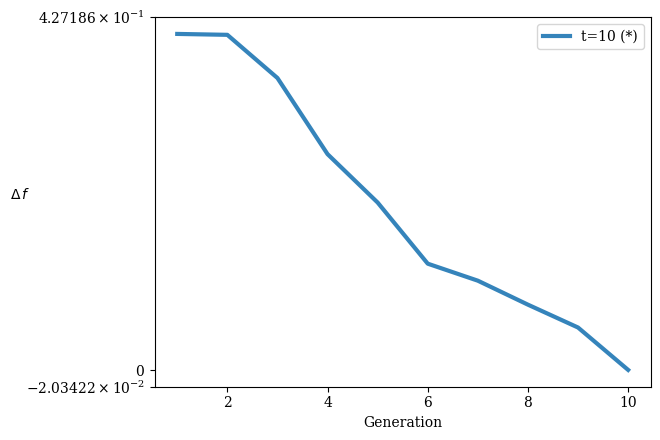

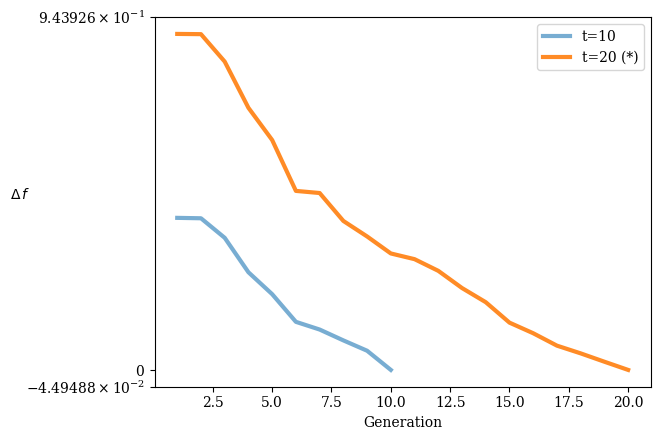

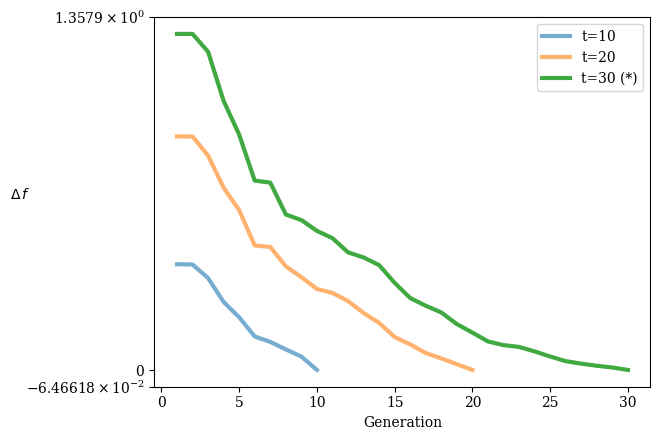

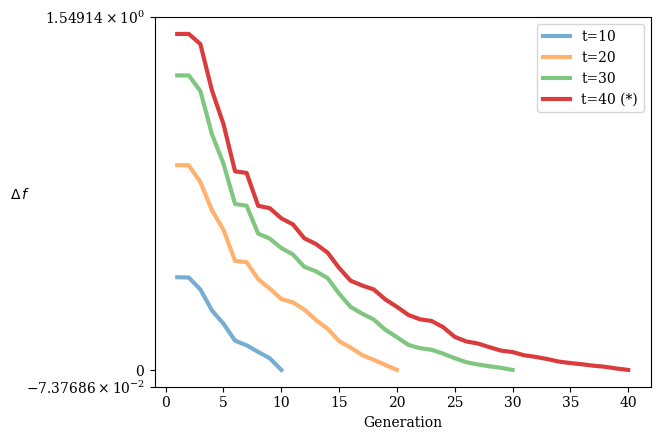

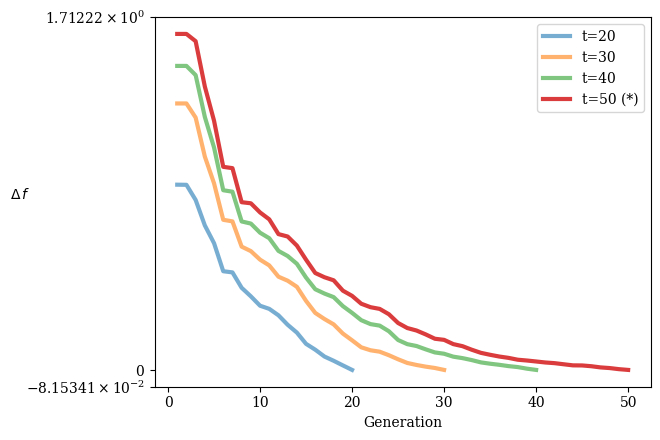

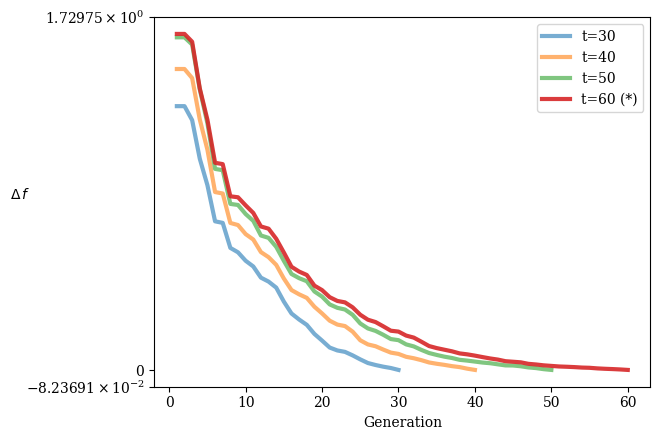

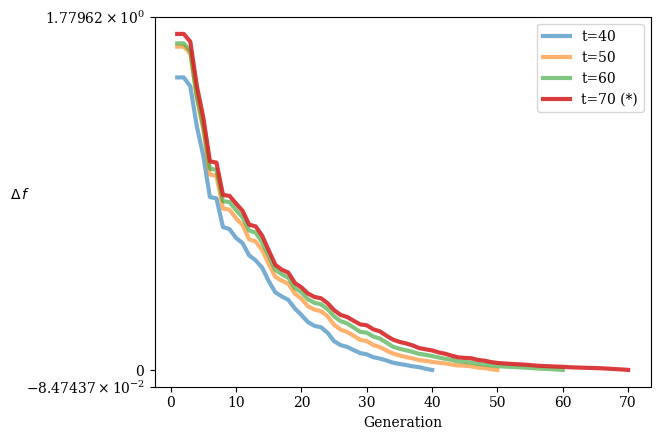

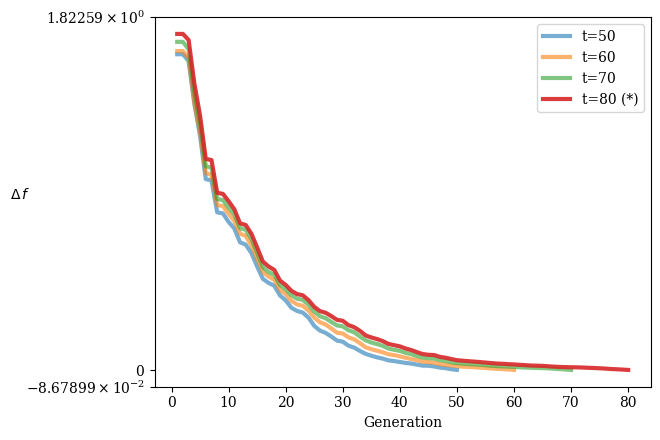

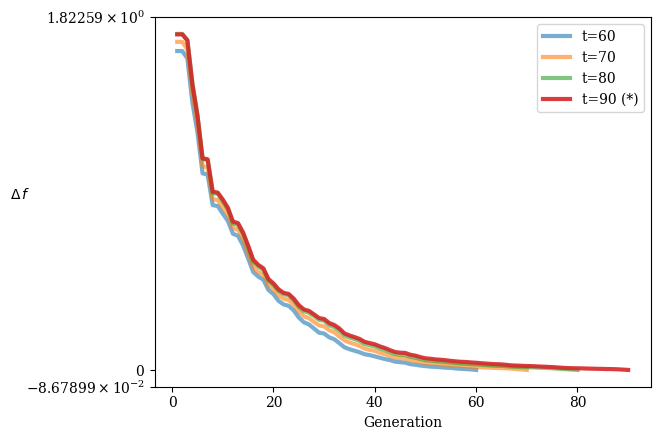

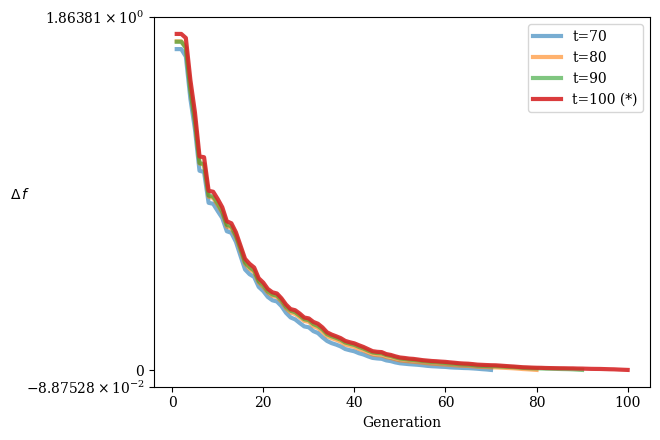

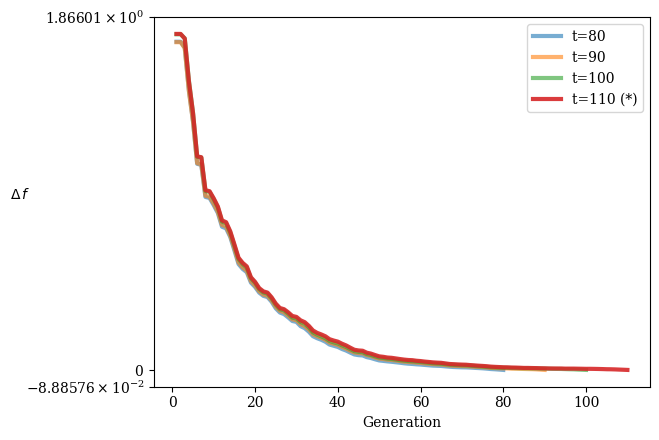

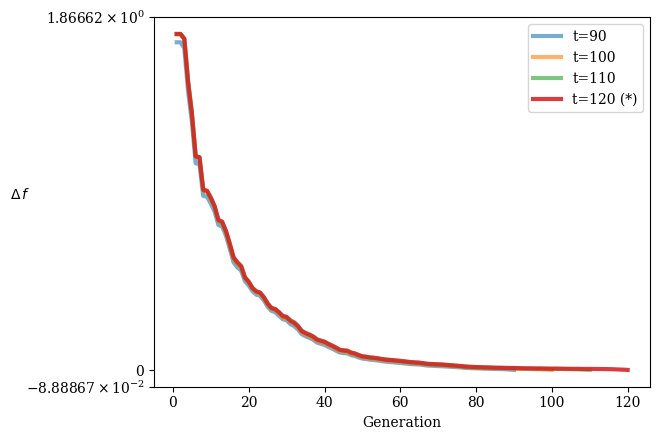

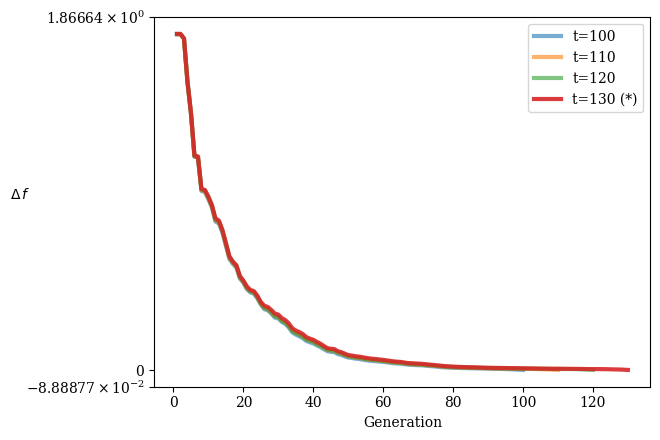

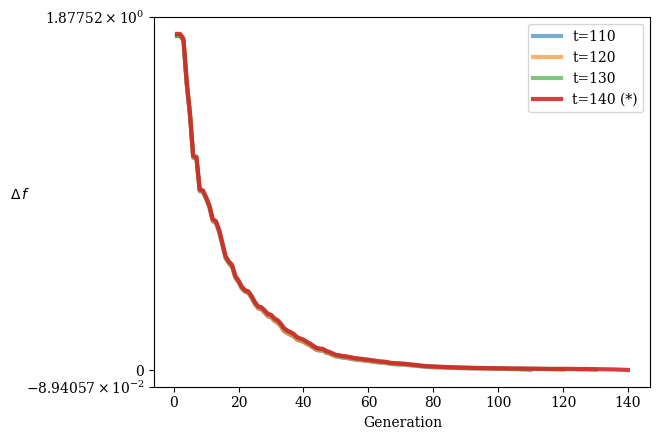

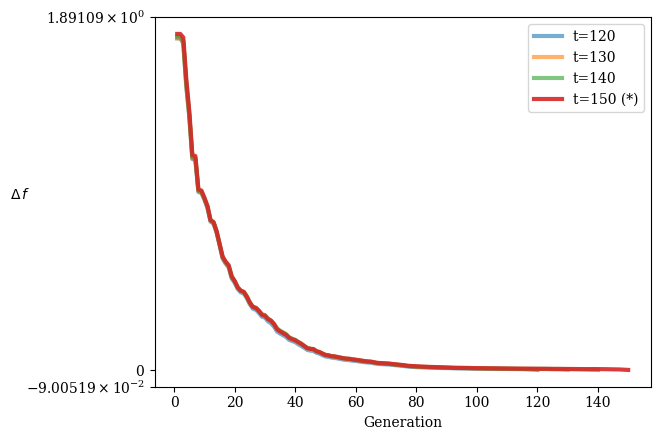

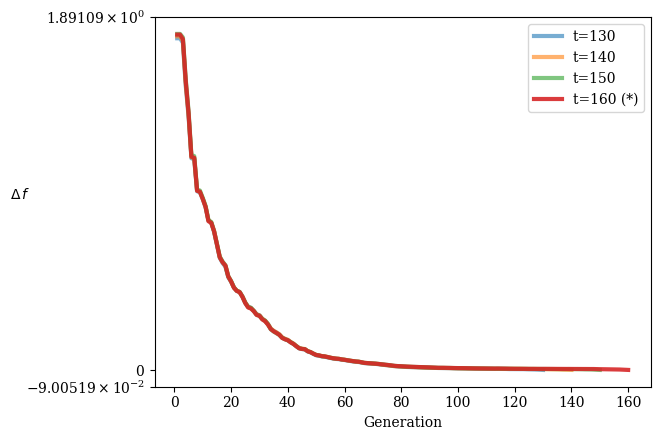

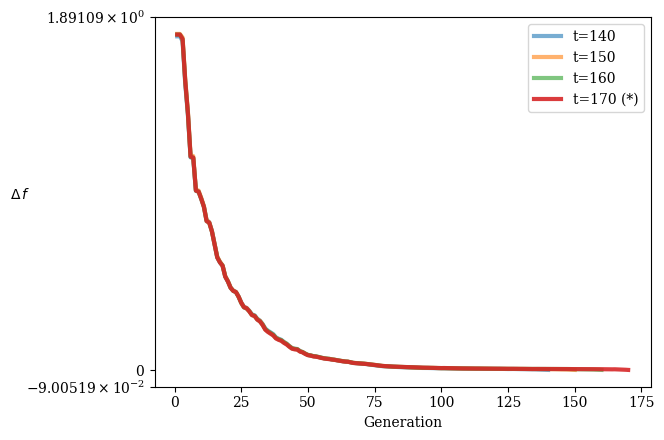

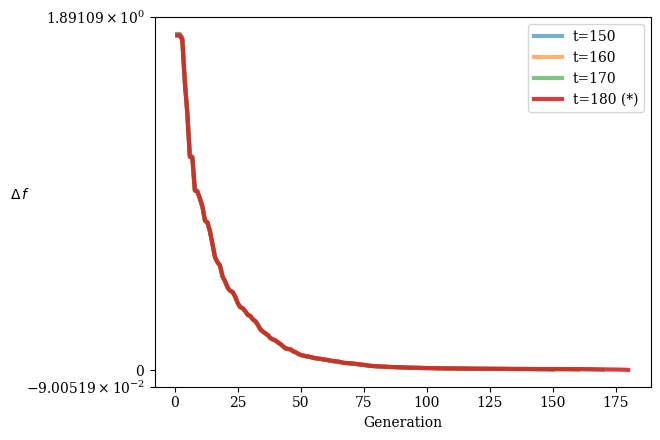

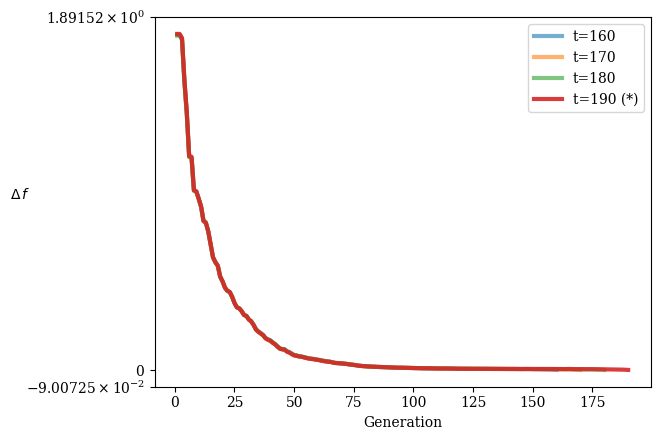

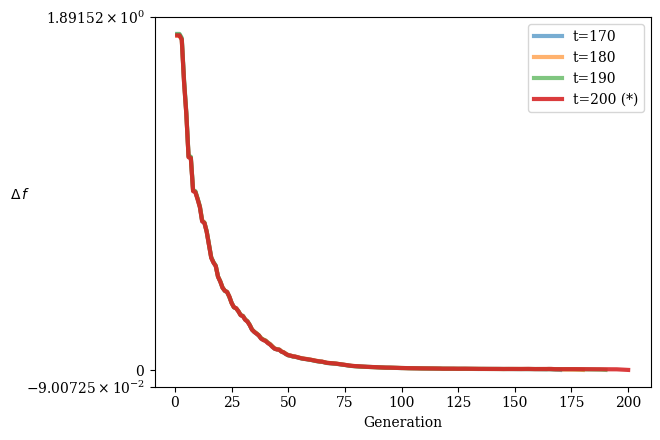

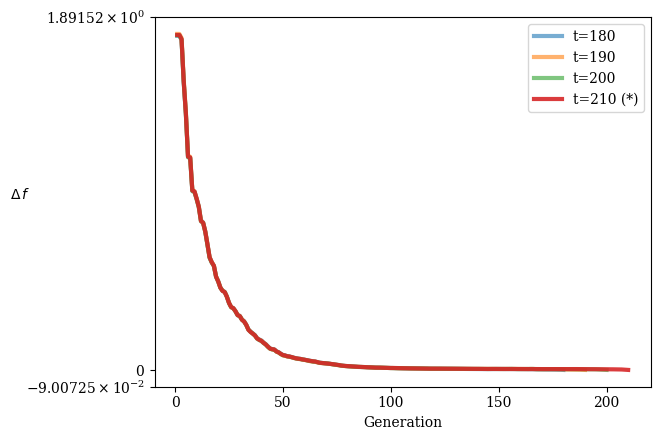

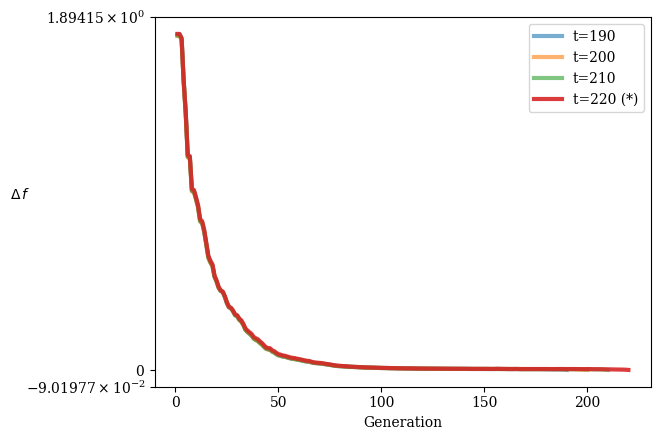

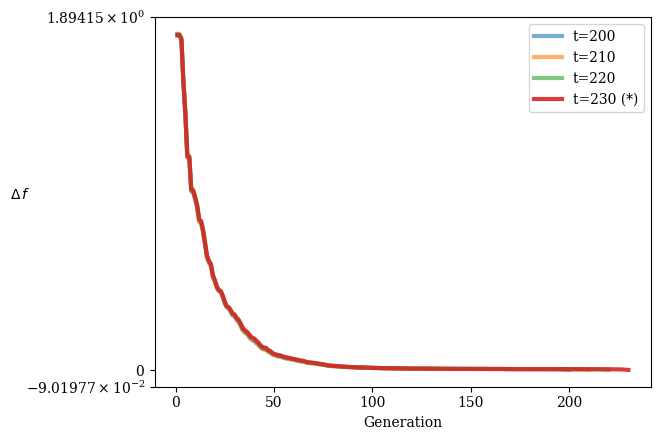

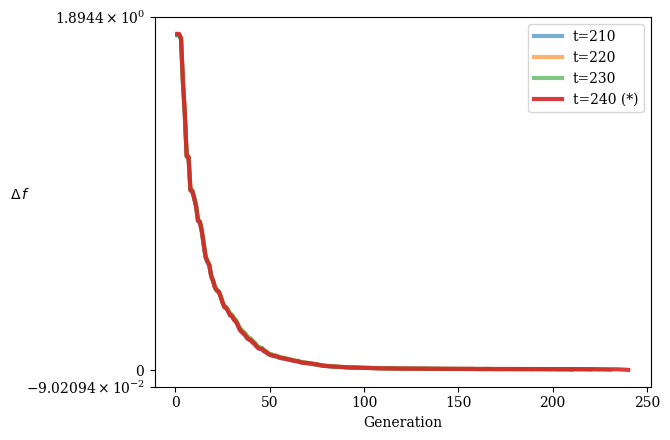

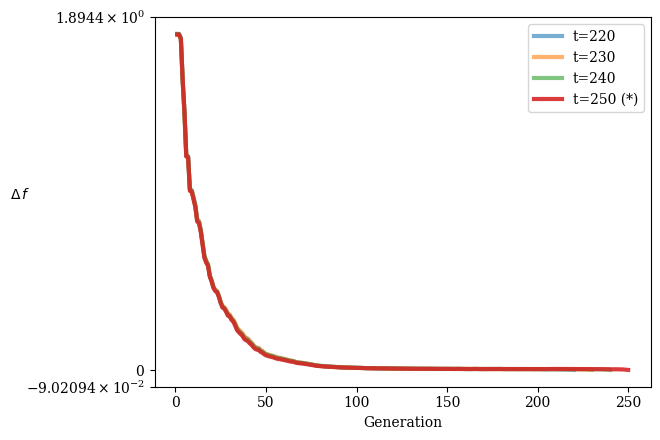

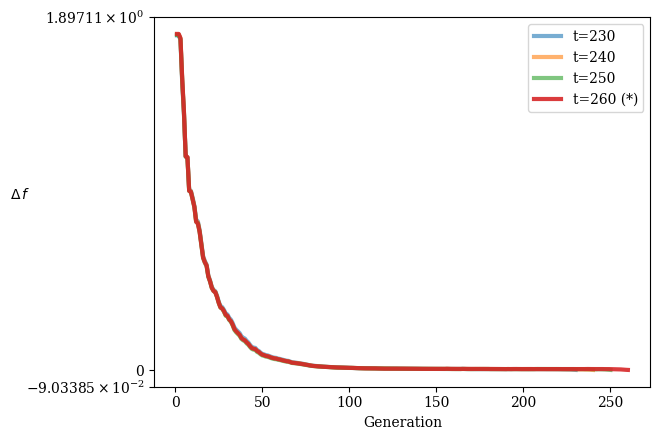

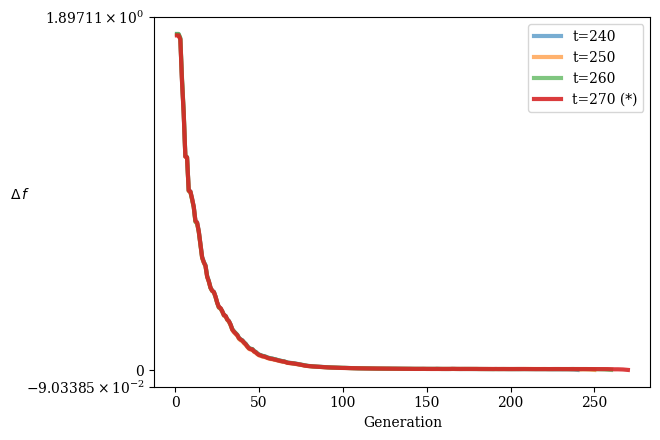

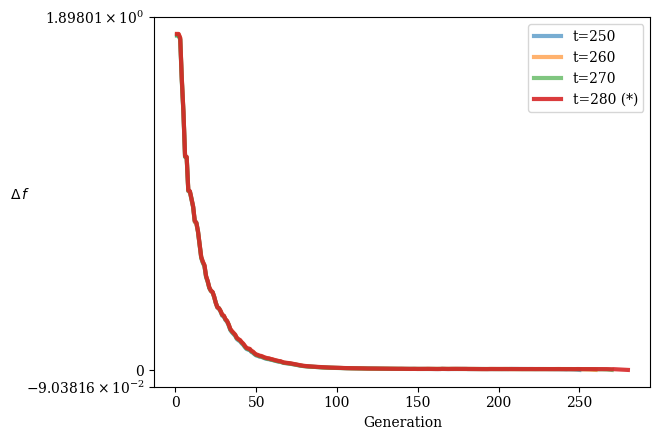

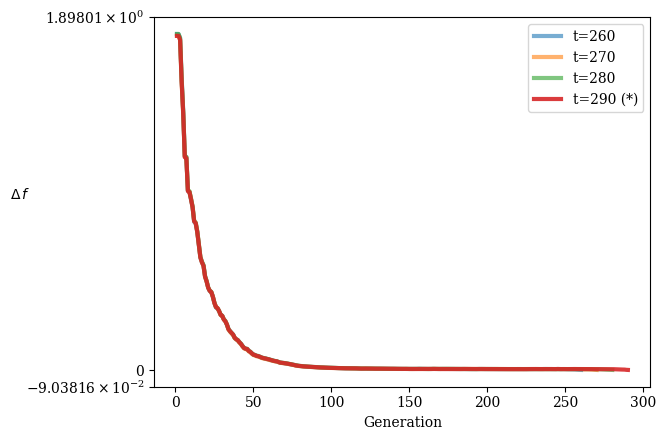

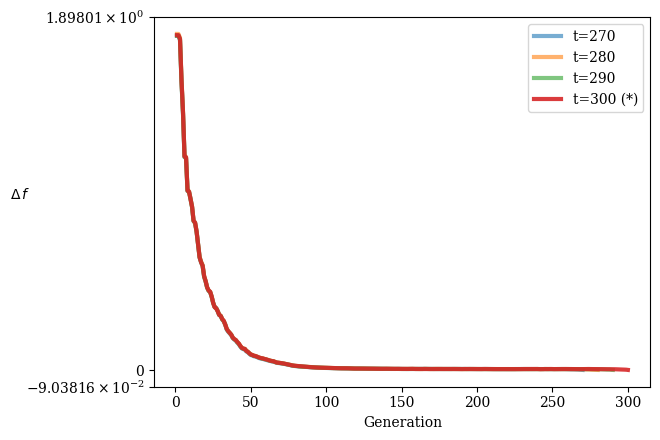

In [42]:
from pymoo.util.running_metric import RunningMetric

running = RunningMetricAnimation(delta_gen=10,
                        n_plots=4,
                        key_press=False,
                        do_show=True)

for algorithm in res3.history:
    running.update(algorithm)

In [43]:
from pymoo.indicators.igd import IGD

metric = IGD(pf, zero_to_one=True)

igd = [metric.do(_F) for _F in hist_F]

plt.plot(n_evals, igd,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, igd,  facecolor="none", edgecolor='black', marker="p")
plt.axhline(10**-2, color="red", label="10^-2", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("IGD")
plt.yscale("log")
plt.legend()
plt.show()

NameError: name 'pf' is not defined